# Quantum Optimal Control through SPSA on fidelity
### Preparation of the Greenberger–Horne–Zeilinger state (GHZ state)

In this notebook we address the task of creating the GHZ state $\frac{|000\rangle +|111\rangle}{\sqrt{2}}$ by optimising on the fidelity

In [1]:

from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
import numpy as np
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src/')
from utils.functions import *

In this cell, we define the quantum circuit designed to prepare the target GHZ state. You can also modify the target state and the initial state directly within this cell, allowing for flexibility in the setup.

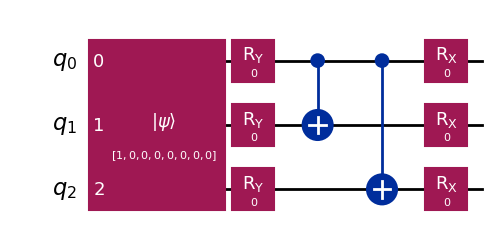

In [2]:
def create_controlled_ghz_circuit(thetas, initial_state):
  
    circ = QuantumCircuit(3)
    # Initialize qubits with the specified state
    circ.initialize(initial_state, [0,1,2])
    # Apply parameterized rotation gates
    circ.ry(thetas[0,0], 0)
    circ.ry(thetas[0,1], 1)
    circ.ry(thetas[0,2], 2)
    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.rx(thetas[0,3], 0)
    circ.rx(thetas[0,4], 1)
    circ.rx(thetas[0,5], 2)

    return circ
target_state = np.array([1 , 0, 0, 0, 0, 0, 0, 1])/np.sqrt(2)
initial_state = np.array([1, 0, 0, 0, 0, 0, 0, 0])
n_thetas = 6 #Number of parameters


ghz_visualization = create_controlled_ghz_circuit(np.zeros(n_thetas)[np.newaxis,:],initial_state)
ghz_visualization.draw('mpl')


We define the function to optimise

In [3]:
def target_function(thetas)  :
    ghz_contr_circuit = create_controlled_ghz_circuit
    _, new_fid_real, _ = get_expectation_values(ghz_contr_circuit, np.array(thetas),initial_state, target_state) #Get the real values
    return -new_fid_real  

We set up our experiment, and calculate metrics of interest.

Because the SPSA algorithm, implemented in Qiskit, does not allow direct access to the values ​​obtained in the function we are optimising, a wrapper of the objective function is made, and the number of evaluations cannot be simply set, so a cut is made in the results obtained, see the last lines of the following cell.

In [4]:
n_run = 20
n_total_timesteps = 200 

params = {'n_runs': n_run,
          'n_total_timesteps':n_total_timesteps,
         
         }

metrics = {
    'best_fidelity_runs': np.zeros(n_run),
    'history_best_fidelity_runs': np.zeros((n_run, n_total_timesteps)),
    'value_losses_runs':np.zeros((n_run,n_total_timesteps)),
    'best_thetas_runs': np.zeros((n_run,n_thetas)),
    }

for iter_run in range(n_run):

    best_fidelity, fidelity_history = -float('inf'), []
    best_thetas, thetas_history = np.zeros(n_thetas), []
    X_train, y_train = [], []
    
    def wrapper_objective_function(params):
        global best_fidelity
        global best_thetas

        y = target_function(params)
        X_train.append(params[0])
        y_train.append(y)

        if np.abs(y)>best_fidelity:
            best_fidelity = np.abs(y)
            best_thetas = params
        fidelity_history.append(best_fidelity)
        thetas_history.append(best_thetas)
        return y

    # Initialise the SPSA optimizer
    optimizer = SPSA(maxiter=n_total_timesteps//2)

    # Initial parameters for the circuit
    initial_params = np.random.rand(n_thetas)[np.newaxis,:]
    results = optimizer.minimize(
            wrapper_objective_function,
            x0=initial_params )

    #We only keep results until n_total_timesteps
    metrics['history_best_fidelity_runs'][iter_run,:] = np.abs(np.array(fidelity_history)[:n_total_timesteps])
    metrics['best_fidelity_runs'][iter_run] = np.abs(np.array(fidelity_history)[n_total_timesteps])
    best_thetas = np.array(thetas_history)[n_total_timesteps]
    metrics['best_thetas_runs'][iter_run,:] = best_thetas



y_train = np.array(y_train)[:n_total_timesteps]
X_train = np.array(X_train)[:n_total_timesteps]

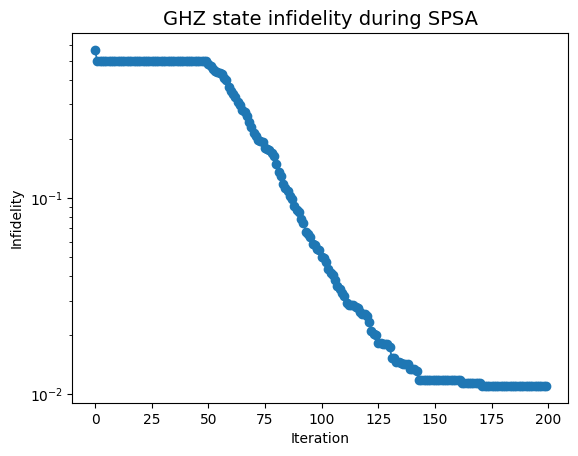

Mean best infidelity:  0.01102956265174071


In [5]:
plt.plot(np.arange(n_total_timesteps),1-np.mean(metrics['history_best_fidelity_runs'],0),'-o', linewidth=1.3)
plt.ylabel('Infidelity')
plt.xlabel('Iteration')
plt.yscale('log')
plt.title('GHZ state infidelity during SPSA', size=14)
plt.show()
print('Mean best infidelity: ',  1-np.mean(metrics['best_fidelity_runs']))


In [6]:
data_plot = {   'history_best_fidelity_runs':metrics['history_best_fidelity_runs'],
                'best_thetas_runs': metrics['best_thetas_runs'],
                'best_fidelity_runs':metrics['best_fidelity_runs'],
            } 
if True:
    with open("../results/qoc/results_ghz_spsa.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

Optionally: Track metrics and parameters in MLflow

In [7]:
import mlflow
#Metrics resume
metrics_reg= {
    'mean_infidelity_runs': 1- np.mean(metrics['best_fidelity_runs']),
    'std_infidelity_runs': np.std(metrics['best_fidelity_runs']),

        }
params['size_final_dataset'] =  y_train.shape[0]

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("QOC_GHZ")

with mlflow.start_run(run_name='GHZ_SPSA'):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)
    

2024/09/21 10:12:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run GHZ_SPSA at: http://127.0.0.1:8080/#/experiments/126759745047636218/runs/df95cb15ccc74004b9273e74ceff55dd.
2024/09/21 10:12:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/126759745047636218.
